In [1]:
from kernel_submission_2 import *

train_df = get_training_data()
train_df = train_df.loc[train_df[target_column].isin([2,3])]
train_df = clean_data(train_df)
train_df = train_df.reset_index()[hh_columns+[household_id, target_column]]
target_household_map = target_by_household(train_df)
train_df = train_df.drop(target_column, axis=1).groupby(household_id).agg(lambda x: scipy.stats.mode(x)[0])
train_df = train_df.join(target_household_map)

/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
X = get_balanced_data(train_df)
X[target_column].value_counts()

3    369
2    369
Name: Target, dtype: int64

High negative correlation:
    - `hogar_nin` : 'Number of children 0 to 19 in household'
    - `r4t1` : 'persons younger than 12 years of age'
    - `overcrowding` : '# persons per room'
    - `r4m1` : 'Females younger than 12 years of age'

Some household totals to get proportions from:
    - `hogar_total` : '# of total individuals in the household'
    - `r4t3` : 'Total persons in the household'
    - `tamhog` : 'size of the household',
    - `tamviv` : 'number of persons living in the household'
    - `hhsize` : 'household size'

In [3]:
# pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), ('scaler', MinMaxScaler())])
# Z = pd.DataFrame(pipeline.fit_transform(X)).rename(columns=dict(enumerate(X.columns)))

In [27]:
print('Most negatively correlated variables:')
print(X.corr()['Target'].sort_values().head(15))

print('\nMost positively correlated variables:')
print(X.corr()['Target'].sort_values().dropna().tail(15))

Most negatively correlated variables:
less-than-3-rooms    -0.127528
building-warning     -0.111191
young-children-3+    -0.098338
overcrowding         -0.087922
edjefa               -0.084624
pct_children         -0.083981
children-3+          -0.076455
missing-rent         -0.074987
cooking-energy       -0.074028
pct_young_children   -0.059836
lugar6               -0.059738
toilet-system        -0.052794
missing-electric     -0.052129
pct_young_female     -0.044443
hacdor               -0.034870
Name: Target, dtype: float64

Most positively correlated variables:
rubbish-disposal      0.061275
hogar_adul            0.062139
lugar1                0.062345
house-ownership       0.075316
rooms                 0.086990
tablets-pp            0.087976
edjefe                0.101079
handheld-tech         0.103683
comforts              0.107174
cielorazo             0.108491
tech                  0.121942
building-quality      0.137707
building-score        0.155677
building-materials    0.16

#### Plot things

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 12
plt.rcParams['patch.edgecolor'] = 'k'

def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}")

Wall material seems to have some relationship

/home/minnie/workspace/poverty-prediction/kernel_submission_2.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[new_col] = np.argmax(np.array(df[old_cols]), axis = 1) + 1


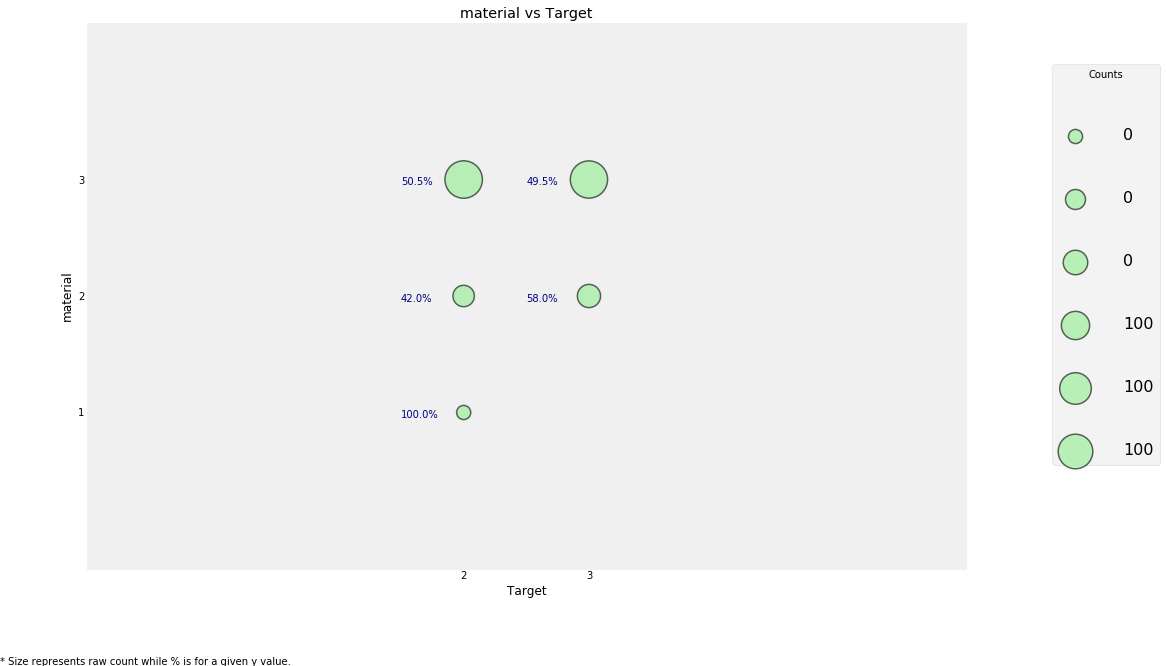

In [7]:
material = ['noelec', 'coopele', 'public', 'planpri']
features = X[material]
features = compress_columns(features, 'material', material).join(X['Target'])
features = get_balanced_data(features, 222, 6)
plot_categoricals('Target','material', features)

#### Make new features

In [8]:
def compress_column_data(df):
    df = compress_electricity(df)
    df = compress_columns(df, 'wall-quality', ['epared1', 'epared2', 'epared3'])
    df = compress_columns(df, 'roof-quality', ['etecho1', 'etecho2', 'etecho3'])
    df = compress_columns(df, 'floor-quality', ['eviv1', 'eviv2', 'eviv3'])
    df = compress_columns(df, 'wall-material', ['paredfibras', 'pareddes', 'paredzinc', 'paredzocalo', 'paredmad', 'paredpreb', 'paredblolad', 'paredother'])
    df = compress_columns(df, 'roof-material', ['techocane', 'techoentrepiso', 'techozinc', 'techootro'])
    df = compress_columns(df, 'floor-material', ['pisonotiene', 'pisonatur', 'pisomadera', 'pisocemento', 'pisomoscer', 'pisoother'])
    df = compress_columns(df, 'cooking-energy', ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4'])
    df = compress_columns(df, 'toilet-system', ['sanitario1', 'sanitario5', 'sanitario3', 'sanitario2', 'sanitario6'])
    df = compress_columns(df, 'rubbish-disposal', ['elimbasu3', 'elimbasu2', 'elimbasu5', 'elimbasu1', 'elimbasu4', 'elimbasu6'])
    df = compress_columns(df, 'water-provision', ['abastaguano', 'abastaguafuera','abastaguadentro'])
    df = compress_columns(df, 'house-ownership', ['tipovivi4', 'tipovivi5', 'tipovivi1', 'tipovivi3', 'tipovivi2'])
    df = compress_columns(df, 'area', ['area1', 'area2'])
    return df
    
X = compress_column_data(X)

In [9]:
X['pct_children'] = X['hogar_nin']/X['hogar_total']
X['pct_young_children'] = X['r4t1']/X['hogar_total']
X['pct_young_female'] = X['r4m1']/X['hogar_total']

In [10]:
X['children-3+'] = (X['hogar_nin']>=3).astype(int)
X['young-children-3+'] = (X['r4t1']>=3).astype(int)

In [11]:
X['less-than-3-rooms'] = (X['rooms']<=3).astype(int)

In [22]:
X['building-quality'] = X['wall-quality'] + X['roof-quality'] + X['floor-quality']
X['building-materials'] = X['wall-material'] + X['roof-material'] + X['floor-material']
X['building-material-quality'] = (X['wall-material']*X['wall-quality'] + 
                                 X['roof-material']*X['roof-quality'] + 
                                 X['floor-material']*X['floor-quality'])
# No toilet, no electric, no cooking, no floor, no water service, no ceiling
X['building-warning'] = ((X['toilet-system'] == 1) + 
                         (X['electric'] == 1) + 
#                          (X['cooking-energy'] == 0) +
#                          (X['floor-material'] == 0) + 
                         (X['water-provision'] == 1) + 
                         (X['cielorazo'] == 0)).astype(int)

/home/minnie/.ve/poverty-prediction/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [13]:
X['building-score'] = (X['wall-quality']/X['wall-quality'].max() + 
                       X['roof-quality']/X['roof-quality'].max() + 
                       X['floor-quality']/X['floor-quality'].max() +
                       X['wall-material']/X['wall-material'].max() +
                       X['roof-material']/X['roof-material'].max() +
                       X['floor-material']/X['floor-material'].max() +
                       X['electric']/X['electric'].max() +
                       X['cooking-energy']/X['cooking-energy'].max() +
                       X['toilet-system']/X['toilet-system'].max() +
                       X['rubbish-disposal']/X['rubbish-disposal'].max() +
                       X['water-provision']/X['water-provision'].max() +
                       X['house-ownership']/X['house-ownership'].max())

In [14]:
X['handheld-tech'] = X['qmobilephone']+X['v18q1']
X['comforts'] = X['computer']+X['refrig']+X['television']
X['tech'] = X['handheld-tech']+X['comforts']
X['tablets-pp'] = X['v18q1']/X['hogar_total']
# X['tablets-pc'] = X['v18q1']/X['hogar_nin']

In [15]:
X['sanitation'] = X['toilet-system']+X['rubbish-disposal']+X['water-provision']

In [24]:
# X.drop('roof-quality', axis=1, inplace=True)
# X.drop('roof-material', axis=1, inplace=True)
# X.drop('v18q1', axis=1, inplace=True)
# X.drop('qmobilephone', axis=1, inplace=True)
# X.drop('building-material-quality', axis=1, inplace=True)
# X.drop('wall-material', axis=1, inplace=True)
# X.drop('floor-quality', axis=1, inplace=True)
# X.drop('wall-quality', axis=1, inplace=True)
# X.drop('floor-material', axis=1, inplace=True)
# X.drop('computer', axis=1, inplace=True)
# X.drop('refrig', axis=1, inplace=True)
# X.drop('television', axis=1, inplace=True)
# X.drop('hogar_nin', axis=1, inplace=True)
# X.drop('r4t1', axis=1, inplace=True)
# X.drop('r4m1', axis=1, inplace=True)
# X.drop('r4h1', axis=1, inplace=True)

KeyError: "['r4t1'] not found in axis"

In [17]:
# X_new = X.drop(columns=['v18q1', 'r4t1', 'hogar_nin', 'edjefe', 'edjefa',
#     'r4h1', 'r4m1', 'computer', 'qmobilephone', 'hacdor', 'r4h2', 'r4t2', 'hogar_adul'])

In [18]:
# columns_by_dtype = X.columns.groupby(X.dtypes)
# {k.name: v for k, v in columns_by_dtype.items()}

In [19]:
# X[['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding',
#         'pct_children', 'pct_young_children', 'pct_young_female', 'tablets-pp',
#         'tablets-pc']].max()

### Train Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# def format_selector(selector,data, target):
#     selector.fit(data, target)
#     features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
#     features = data[[data.columns.values[i] for i in features]]
#     print(features.columns)
#     return features

# selector = SelectKBest(chi2, k=15)
# data = X_new.drop('Target', axis=1)
# target = X_new['Target']

# data = format_selector(selector, data, target)
data = X[['building-materials','building-score','building-quality','less-than-3-rooms','tech','building-warning',
'cielorazo','comforts','handheld-tech','edjefe','Target']]

model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs = -1)
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

train_labels = np.array(list(X['Target'].astype(np.uint8)))
train_set = X.drop('Target', axis=1)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

train_set = pipeline.fit_transform(train_set)

# 10 fold cross validation
cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

10 Fold Cross Validation F1 Score = 0.5601 with std = 0.0611


In [32]:
from sklearn.metrics import classification_report

v = get_balanced_data(X, 50, 5)
t = pd.concat([X.reset_index(), v.reset_index()]).drop_duplicates(keep=False).set_index(household_id)

train_labels = np.array(list(t['Target'].astype(np.uint8)))
train_set = t.drop(columns = ['Target'])
test_set = v.drop(columns = ['Target'])

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

train_set = pipeline.fit_transform(train_set)
test_set = pipeline.transform(test_set)

clf = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs = -1)
clf.fit(train_set, train_labels)
preds = clf.predict(test_set)
print(classification_report(v['Target'], preds))

             precision    recall  f1-score   support

          2       0.57      0.64      0.60        50
          3       0.59      0.52      0.55        50

avg / total       0.58      0.58      0.58       100

